# Cosmological Power Spectrum Analysis with MCMC

This notebook demonstrates the full workflow of the MCP-KE cosmology tools:

1. **Setup** - Imports and configuration
2. **Load Data** - Real eBOSS DR14 Lyman-α observations
3. **Compute Power Spectra** - Theory predictions for multiple cosmological models
4. **Visualization** - Plot power spectra and suppression ratios
5. **MCMC Parameter Estimation** - Bayesian inference for cosmological parameters
6. **Analyze Results** - Corner plots, trace plots, and best-fit predictions

## 1. Setup

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Import cosmology modules
from codes.cosmology_models import (
    base_params, LCDM, nu_mass, wCDM, 
    thermal_WDM_all_dm, mixed_CWDM, define_cosmology_models
)
from codes.analysis import (
    compute_power_spectrum, compute_all_models, compute_suppression_ratios
)
from codes.mcmc import (
    run_mcmc, extract_mcmc_results, format_mcmc_summary,
    save_mcmc_samples, load_mcmc_samples,
    create_corner_plot, create_trace_plot
)
from codes.data import load_observational_data

# Create output directory for this notebook
OUTPUT_DIR = os.path.join(os.getcwd(), 'output')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.environ['MCP_OUTPUT_DIR'] = OUTPUT_DIR

print(f"Output directory: {OUTPUT_DIR}")
print("Setup complete!")

Output directory: /Users/nesar/Projects/HEP/AmSC_HEP/mcp-ke/notebooks/output
Setup complete!


In [2]:
! which python

/Users/nesar/Projects/HEP/AmSC_HEP/.conda/bin/python


## 2. Load Observational Data

We load real power spectrum observations from the eBOSS DR14 Lyman-α forest data.

In [3]:
# Load real observational data (eBOSS DR14 Lyman-alpha)
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'DR14_pm3d_19kbins.txt')
k_obs, Pk_obs, Pk_obs_err = load_observational_data(DATA_PATH)

print(f"Loaded observational data with {len(k_obs)} k-bins")
print(f"k range: [{k_obs.min():.3f}, {k_obs.max():.3f}] h/Mpc")
print(f"P(k) range: [{Pk_obs.min():.2e}, {Pk_obs.max():.2e}] (Mpc/h)^3")

Loaded observational data with 19 k-bins
k range: [0.208, 2.521] h/Mpc
P(k) range: [3.44e+00, 8.04e+02] (Mpc/h)^3


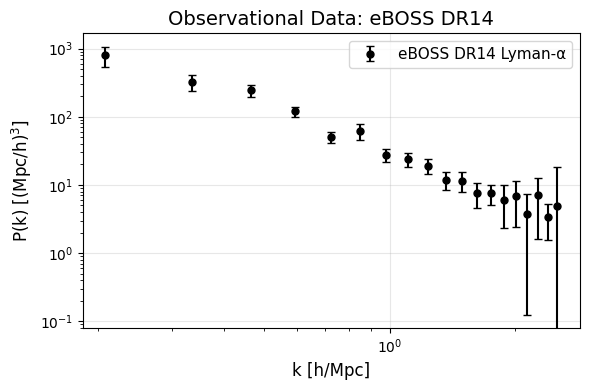

In [4]:
# Quick visualization of observational data
plt.figure(figsize=(6, 4))
plt.errorbar(k_obs, Pk_obs, yerr=Pk_obs_err, fmt='o', color='black', 
             label='eBOSS DR14 Lyman-α', capsize=3, markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h/Mpc]', fontsize=12)
plt.ylabel('P(k) [(Mpc/h)$^3$]', fontsize=12)
plt.title('Observational Data: eBOSS DR14', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'observational_data.png'), dpi=150)
plt.show()

## 3. Compute Power Spectra for Multiple Models

Compare different cosmological models: ΛCDM, massive neutrinos, wCDM, and warm dark matter.

In [5]:
# Create fine theory k-grid for smooth curves
k_theory = np.logspace(-3, np.log10(5), 200)

# Compute power spectra for all standard models
print("Computing power spectra for cosmological models...")
model_results = compute_all_models(k_theory)

print(f"\nComputed {len(model_results)} models:")
for name in model_results.keys():
    print(f"  - {name}")

Computing power spectra for cosmological models...

Computed 7 models:
  - ΛCDM
  - ΛCDM + Σmν=0.10 eV
  - wCDM (w0=-0.9)
  - Thermal WDM (all DM, m=3 keV)
  - CWDM (f_wdm=0.2, m=3 keV, g*=100)
  - ETHOS IDM–DR (fiducial)
  - IDM–baryon (σ=1e-41 cm², n=-4)


In [6]:
# Compute suppression ratios relative to ΛCDM
suppression = compute_suppression_ratios(model_results, k_theory, reference_model='ΛCDM')

print("Suppression ratios computed for:")
for name in suppression.keys():
    # Find suppression at k=1 h/Mpc
    k_idx = np.argmin(np.abs(k_theory - 1.0))
    ratio = suppression[name][k_idx]
    print(f"  {name}: {ratio:.4f} at k=1 h/Mpc")

Suppression ratios computed for:
  ΛCDM + Σmν=0.10 eV: 0.8943 at k=1 h/Mpc
  wCDM (w0=-0.9): 1.2292 at k=1 h/Mpc
  Thermal WDM (all DM, m=3 keV): 0.9538 at k=1 h/Mpc
  CWDM (f_wdm=0.2, m=3 keV, g*=100): 0.9978 at k=1 h/Mpc
  ETHOS IDM–DR (fiducial): 0.7834 at k=1 h/Mpc
  IDM–baryon (σ=1e-41 cm², n=-4): 1.0000 at k=1 h/Mpc


## 4. Visualization

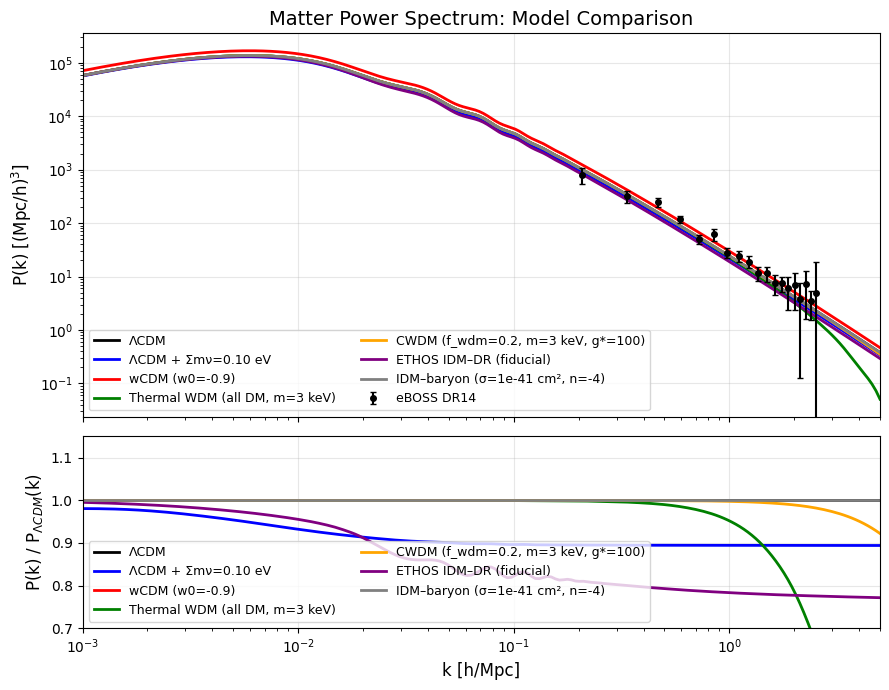

In [7]:
# Color scheme for models
colors = {
    'ΛCDM': 'black',
    'ΛCDM + Σmν=0.10 eV': 'blue',
    'wCDM (w0=-0.9)': 'red',
    'Thermal WDM (all DM, m=3 keV)': 'green',
    'CWDM (f_wdm=0.2, m=3 keV, g*=100)': 'orange',
    'ETHOS IDM–DR (fiducial)': 'purple',
}

fig, axes = plt.subplots(2, 1, figsize=(9, 7), height_ratios=[2, 1], sharex=True)

# Top panel: Power spectra
ax1 = axes[0]
for name, Pk in model_results.items():
    color = colors.get(name, 'gray')
    ax1.plot(k_theory, Pk, color=color, linewidth=2, label=name)

# Add observational data
ax1.errorbar(k_obs, Pk_obs, yerr=Pk_obs_err, fmt='o', color='black', 
             label='eBOSS DR14', capsize=2, markersize=4, zorder=10)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('P(k) [(Mpc/h)$^3$]', fontsize=12)
ax1.set_title('Matter Power Spectrum: Model Comparison', fontsize=14)
ax1.legend(loc='lower left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1e-3, 5)

# Bottom panel: Suppression ratios
ax2 = axes[1]
ax2.axhline(1.0, color='black', linestyle='-', linewidth=2, label='ΛCDM')

for name, ratio in suppression.items():
    color = colors.get(name, 'gray')
    ax2.plot(k_theory, ratio, color=color, linewidth=2, label=name)

ax2.set_xscale('log')
ax2.set_xlabel('k [h/Mpc]', fontsize=12)
ax2.set_ylabel('P(k) / P$_{\\Lambda CDM}$(k)', fontsize=12)
ax2.set_ylim(0.7, 1.15)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower left', fontsize=9, ncol=2)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'power_spectra_comparison.png'), dpi=150)
plt.show()

## 5. MCMC Parameter Estimation

Now we'll use MCMC to recover the cosmological parameters from our mock observations. We'll fit for `h` (Hubble parameter) and `Omega_cdm` (cold dark matter density).

In [8]:
# Define parameter bounds for MCMC
# Reasonable priors for cosmological parameters
param_bounds = [
    {'name': 'h', 'min': 0.60, 'max': 0.75},
    {'name': 'Omega_cdm', 'min': 0.10, 'max': 0.14},
]

print("Parameter bounds for MCMC:")
for pb in param_bounds:
    print(f"  {pb['name']}: [{pb['min']}, {pb['max']}]")

Parameter bounds for MCMC:
  h: [0.6, 0.75]
  Omega_cdm: [0.1, 0.14]


In [9]:
# MCMC configuration
NWALKERS = 32      # Number of walkers (should be >= 2 * ndim)
NBURN = 50         # Burn-in steps
NRUN = 400         # Production steps

print(f"Running MCMC with {NWALKERS} walkers...")
print(f"  Burn-in: {NBURN} steps")
print(f"  Production: {NRUN} steps")
print(f"  Total samples: {NWALKERS * NRUN:,}")
print("\nThis may take a few minutes...\n")

# Run MCMC
mcmc_result = run_mcmc(
    param_bounds=param_bounds,
    base_params=base_params(),
    k_obs=k_obs,
    Pk_obs=Pk_obs,
    Pk_obs_err=Pk_obs_err,
    nwalkers=NWALKERS,
    nburn=NBURN,
    nrun=NRUN,
    prior_type='uniform',
    progress=False  # Set True for progress bar in terminal
)

print("MCMC complete!")
print(f"Acceptance fraction: {mcmc_result['acceptance_fraction']:.3f}")

Running MCMC with 32 walkers...
  Burn-in: 50 steps
  Production: 400 steps
  Total samples: 12,800

This may take a few minutes...

MCMC complete!
Acceptance fraction: 0.679


In [10]:
# Extract and display results
samples = mcmc_result['samples']
param_names = mcmc_result['param_names']

results = extract_mcmc_results(samples, param_names)

print("\n" + "="*50)
print("MCMC RESULTS")
print("="*50)

for name in param_names:
    r = results[name]
    print(f"\n{name}:")
    print(f"  Median: {r['median']:.6f} +{r['upper_err']:.6f} -{r['lower_err']:.6f}")
    print(f"  68% CI: [{r['lower']:.6f}, {r['upper']:.6f}]")


MCMC RESULTS

h:
  Median: 0.690247 +0.040125 -0.042350
  68% CI: [0.647897, 0.730372]

Omega_cdm:
  Median: 0.125019 +0.009811 -0.008744
  68% CI: [0.116275, 0.134831]


In [11]:
# Save MCMC samples
samples_path = os.path.join(OUTPUT_DIR, 'mcmc_samples.csv')
save_mcmc_samples(samples, param_names, samples_path)
print(f"Samples saved to: {samples_path}")

Samples saved to: /Users/nesar/Projects/HEP/AmSC_HEP/mcp-ke/notebooks/output/mcmc_samples.csv


## 6. MCMC Diagnostics

Trace plot saved to: /Users/nesar/Projects/HEP/AmSC_HEP/mcp-ke/notebooks/output/mcmc_trace.png


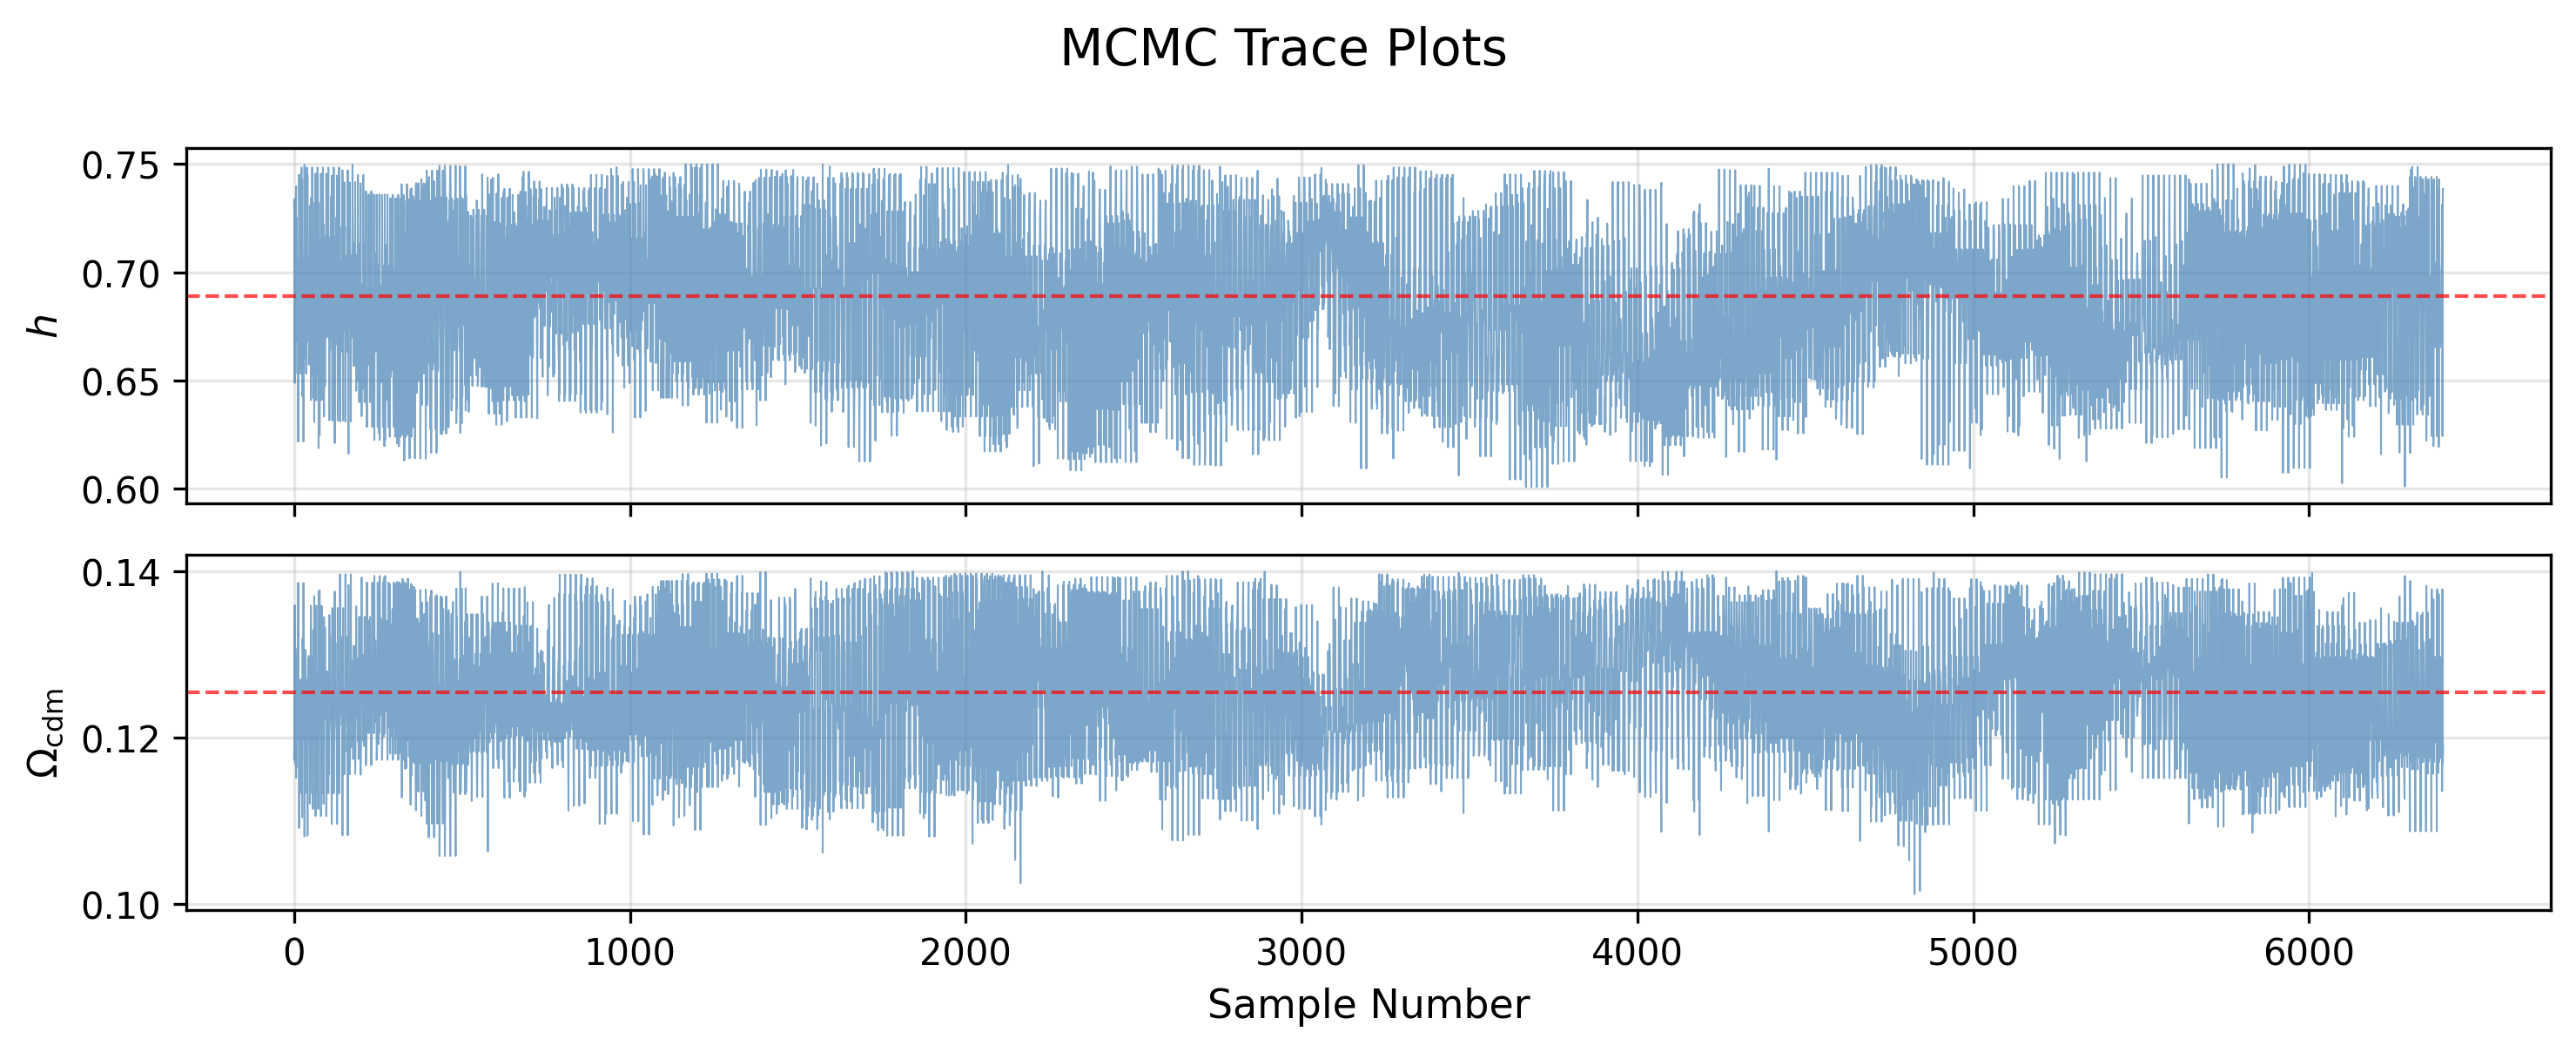

In [12]:
# Create trace plot
trace_path = create_trace_plot(
    chain=samples,
    param_names=param_names,
    param_labels={'h': r'h', 'Omega_cdm': r'\Omega_{\rm cdm}'},
    output_path=os.path.join(OUTPUT_DIR, 'mcmc_trace.png')
)
print(f"Trace plot saved to: {trace_path}")

# Display
from IPython.display import Image, display
display(Image(filename=trace_path))

Removed no burn in
Corner plot saved to: /Users/nesar/Projects/HEP/AmSC_HEP/mcp-ke/notebooks/output/mcmc_corner.png


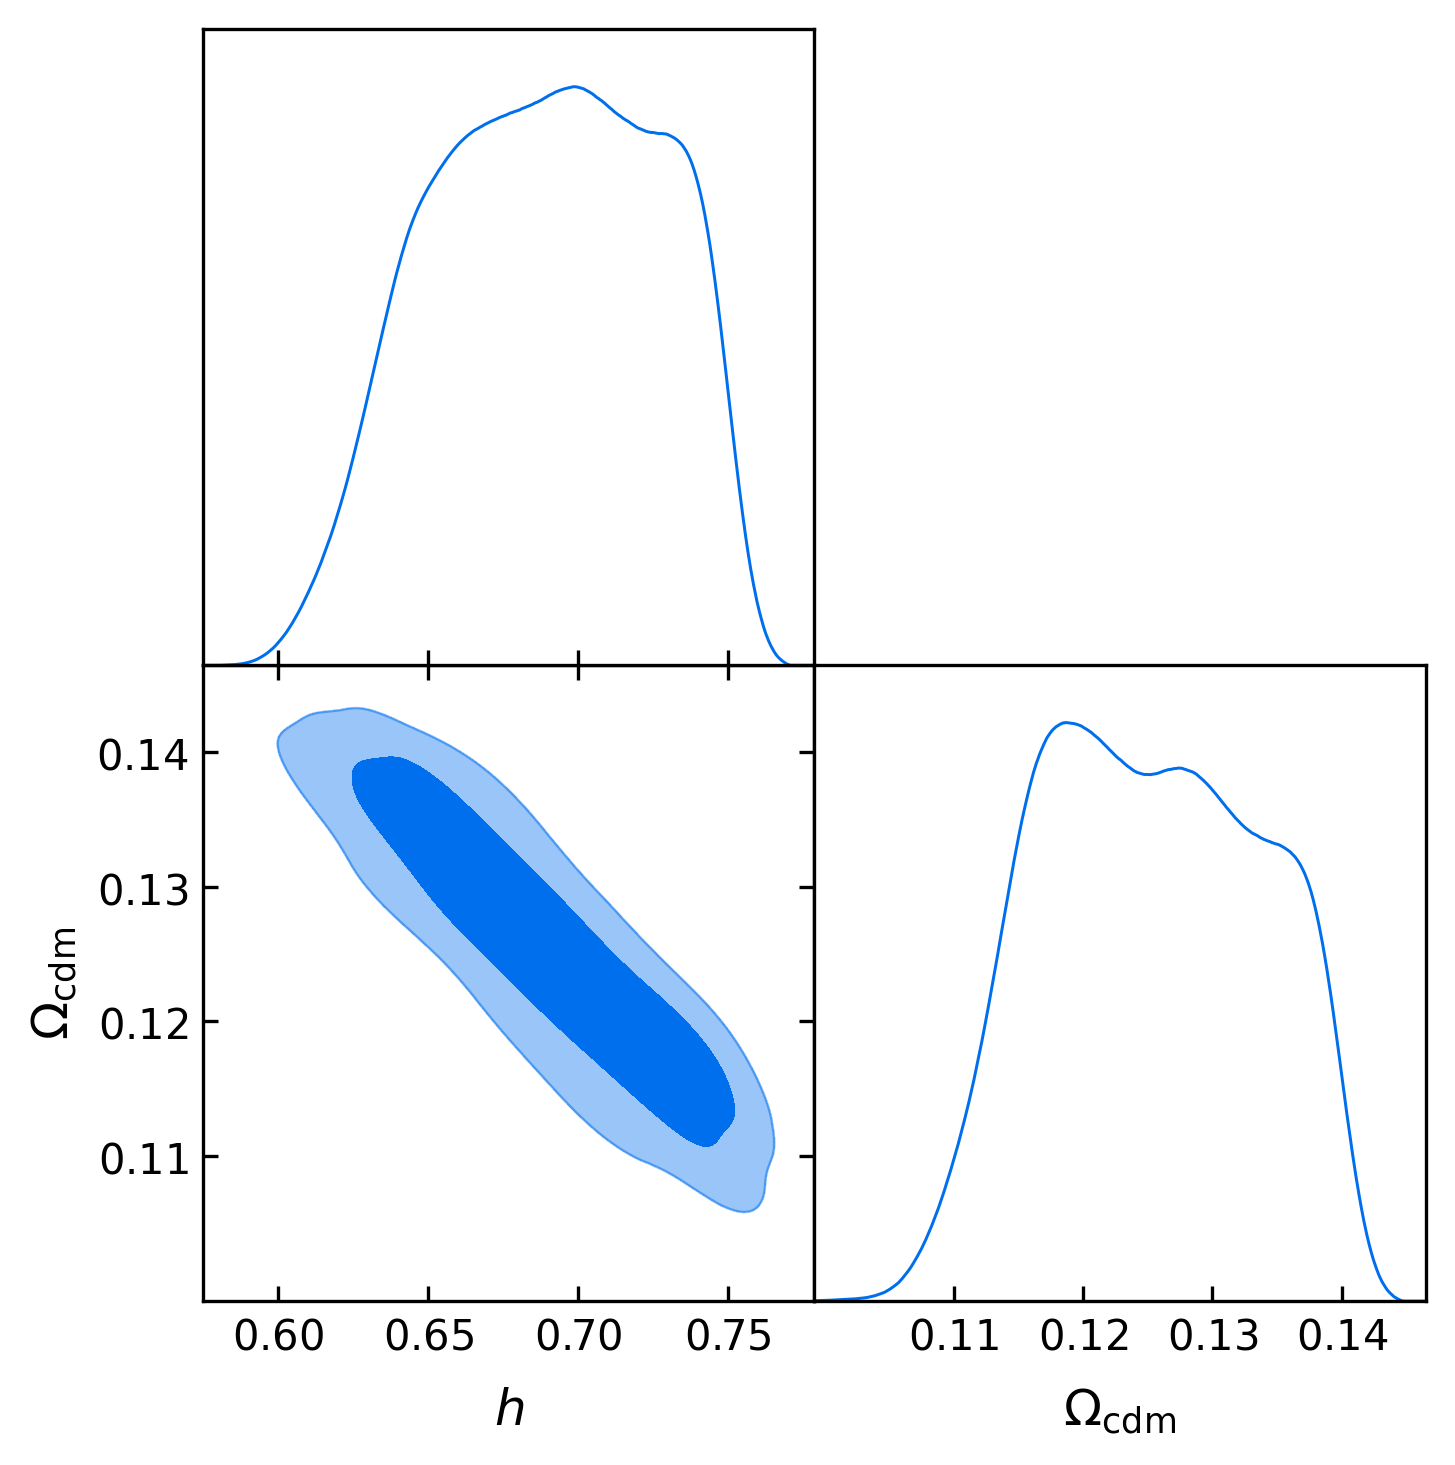

In [20]:
# Create corner plot
corner_path = create_corner_plot(
    samples=samples,
    param_names=param_names,
    param_labels={'h': r'h', 'Omega_cdm': r'\Omega_{\rm cdm}'},
    # title='Posterior Distribution (eBOSS DR14)',
    smooth_scale=2.0,
    output_path=os.path.join(OUTPUT_DIR, 'mcmc_corner.png',)
)
print(f"Corner plot saved to: {corner_path}")

# Display
display(Image(filename=corner_path))

## 7. Best-Fit Predictions

In [21]:
# Compute power spectrum with best-fit parameters
best_fit_params = base_params()
for name in param_names:
    best_fit_params[name] = results[name]['median']

print("Best-fit parameters:")
for name in param_names:
    print(f"  {name} = {best_fit_params[name]:.6f}")

# Compute P(k) for best-fit
Pk_bestfit = compute_power_spectrum(best_fit_params, k_theory)
Pk_bestfit_obs = compute_power_spectrum(best_fit_params, k_obs)

# Compute chi-squared
chi2 = np.sum(((Pk_obs - Pk_bestfit_obs) / Pk_obs_err)**2)
ndof = len(k_obs) - len(param_names)
chi2_reduced = chi2 / ndof

print(f"\nGoodness of fit:")
print(f"  Chi-squared: {chi2:.2f}")
print(f"  Degrees of freedom: {ndof}")
print(f"  Reduced chi-squared: {chi2_reduced:.2f}")

Best-fit parameters:
  h = 0.690247
  Omega_cdm = 0.125019

Goodness of fit:
  Chi-squared: 9.94
  Degrees of freedom: 17
  Reduced chi-squared: 0.58


In [22]:
# Final comparison plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[3, 1], sharex=True)

# Top panel: P(k)
ax1 = axes[0]
ax1.errorbar(k_obs, Pk_obs, yerr=Pk_obs_err, fmt='o', color='black', 
             label='eBOSS DR14 Lyman-α', capsize=3, markersize=6, zorder=5)
ax1.plot(k_theory, Pk_bestfit, 'r-', linewidth=2, 
         label=f'Best-fit (h={results["h"]["median"]:.4f}, Ωcdm={results["Omega_cdm"]["median"]:.4f})')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('P(k) [(Mpc/h)$^3$]', fontsize=12)
ax1.set_title(f'MCMC Best-Fit Result (χ²/dof = {chi2_reduced:.2f})', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom panel: Residuals
ax2 = axes[1]
residuals = (Pk_obs - Pk_bestfit_obs) / Pk_obs_err
ax2.errorbar(k_obs, residuals, yerr=1, fmt='o', color='black', capsize=3, markersize=6)
ax2.axhline(0, color='red', linestyle='-', linewidth=2)
ax2.axhline(-2, color='gray', linestyle='--', linewidth=1)
ax2.axhline(2, color='gray', linestyle='--', linewidth=1)
ax2.fill_between([k_obs.min()*0.5, k_obs.max()*2], -2, 2, alpha=0.1, color='gray')

ax2.set_xscale('log')
ax2.set_xlabel('k [h/Mpc]', fontsize=12)
ax2.set_ylabel('Residuals [σ]', fontsize=12)
ax2.set_ylim(-4, 4)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'mcmc_bestfit.png'), dpi=150)
plt.show()

/var/folders/vm/qp949rjn7_gckc6x9kmm0kbc0000gp/T/ipykernel_51476/2160595688.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Summary

This notebook demonstrated:

1. **Real observational data** from eBOSS DR14 Lyman-α forest
2. **Multi-model power spectrum computation** (ΛCDM, massive neutrinos, wCDM, WDM)
3. **Visualization** of power spectra and suppression ratios
4. **MCMC parameter estimation** using emcee
5. **Diagnostic plots** (trace plots, corner plots)
6. **Best-fit analysis** with residuals and chi-squared

The MCMC provides posterior constraints on cosmological parameters from real Lyman-α data.

In [23]:
# List all output files
print("Generated output files:")
print("=" * 40)
for f in sorted(os.listdir(OUTPUT_DIR)):
    filepath = os.path.join(OUTPUT_DIR, f)
    size_kb = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size_kb:.1f} KB)")

Generated output files:
  mcmc_bestfit.png (83.3 KB)
  mcmc_corner.png (91.1 KB)
  mcmc_samples.csv (495.7 KB)
  mcmc_trace.png (345.4 KB)
  observational_data.png (32.2 KB)
  power_spectra_comparison.png (153.0 KB)
